# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_tree_singlebatch"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cuda:3


'Dec14-1907'

In [4]:
group_key = 'depth'
batch_key = 'batch'
state_key = 'branch'
leiden_key = 'leiden_no_noise'
time_key = 'time'
state_type = 'tree'
batch_type = 'batch_specific_features'
distribution = 'normal'

In [6]:
from Concord.utils.simulation import Simulation

sim = Simulation(n_cells=1024, n_genes=128, n_batches=1, n_states=3, 
                 state_type=state_type, 
                 state_distribution = distribution, 
                 state_level=10, 
                 state_min_level=1,
                 state_dispersion=2.0, 
                 program_structure='dimension_increase',
                 program_on_time_fraction=0.1,
                 trajectory_program_num=4,
                 trajectory_loop_to=1,
                 tree_branching_factor=2,
                 tree_depth=2,
                 tree_program_decay=0.7,
                 batch_distribution=distribution,
                 batch_type=batch_type, 
                 batch_level=[10,10], 
                 batch_dispersion=[2.0, 2.0], 
                 non_neg=True, to_int=True,
                 seed=42)

# Generate the simulated data
adata, adata_state = sim.simulate_data()


Concord.utils.simulation - INFO - Simulating tree with branching factor 2, depth 2, distribution: normal with mean expression 10 and dispersion 2.0.
Concord.utils.simulation - WARNING - Total number of genes will not be equal to n_genes due to program_decay < 1.
Concord.utils.simulation - INFO - Simulating batch-specific features effect on batch_1 by appending a set of batch-specific genes with normal distributed value with level 10 and dispersion 2.0.


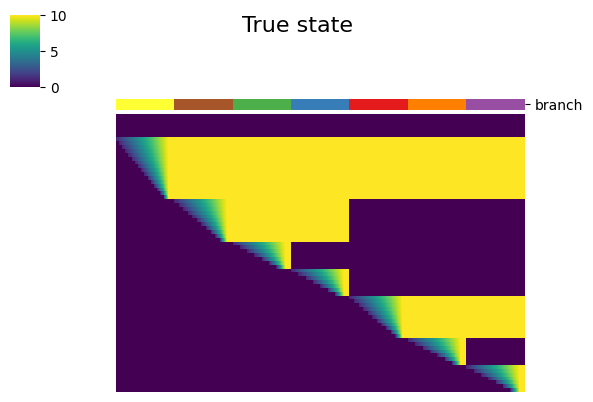

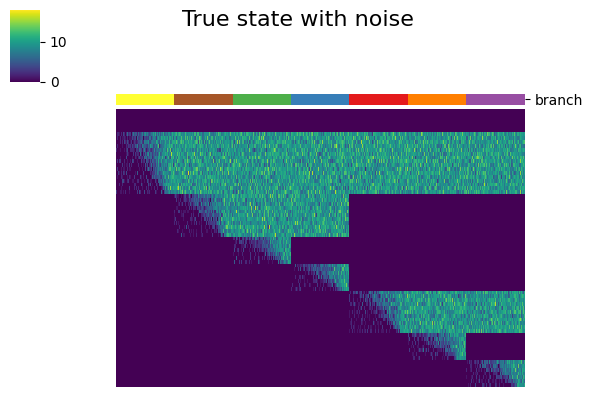

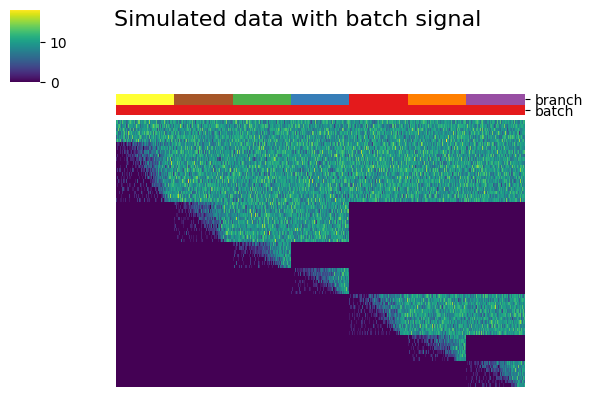

In [7]:
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)

In [8]:
adata.shape

(896, 72)

### No batch effect, no noise

In [9]:
n_components = 15
ccd.ul.run_pca(adata, source_key='no_noise', result_key='PCA_no_noise', n_pc=n_components, random_state=seed)
ccd.ul.run_umap(adata, source_key='no_noise', result_key='UMAP_no_noise', random_state=seed)
sc.pp.neighbors(adata, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata, resolution=1.0, key_added=leiden_key, random_state=seed)
#adata.obs[leiden_key] = adata_state.obs[leiden_key]

Concord - INFO - PCA performed on source data with 15 components
Concord - INFO - PCA embedding stored in adata.obsm['PCA_no_noise']
Concord - INFO - UMAP embedding stored in adata.obsm['UMAP_no_noise']


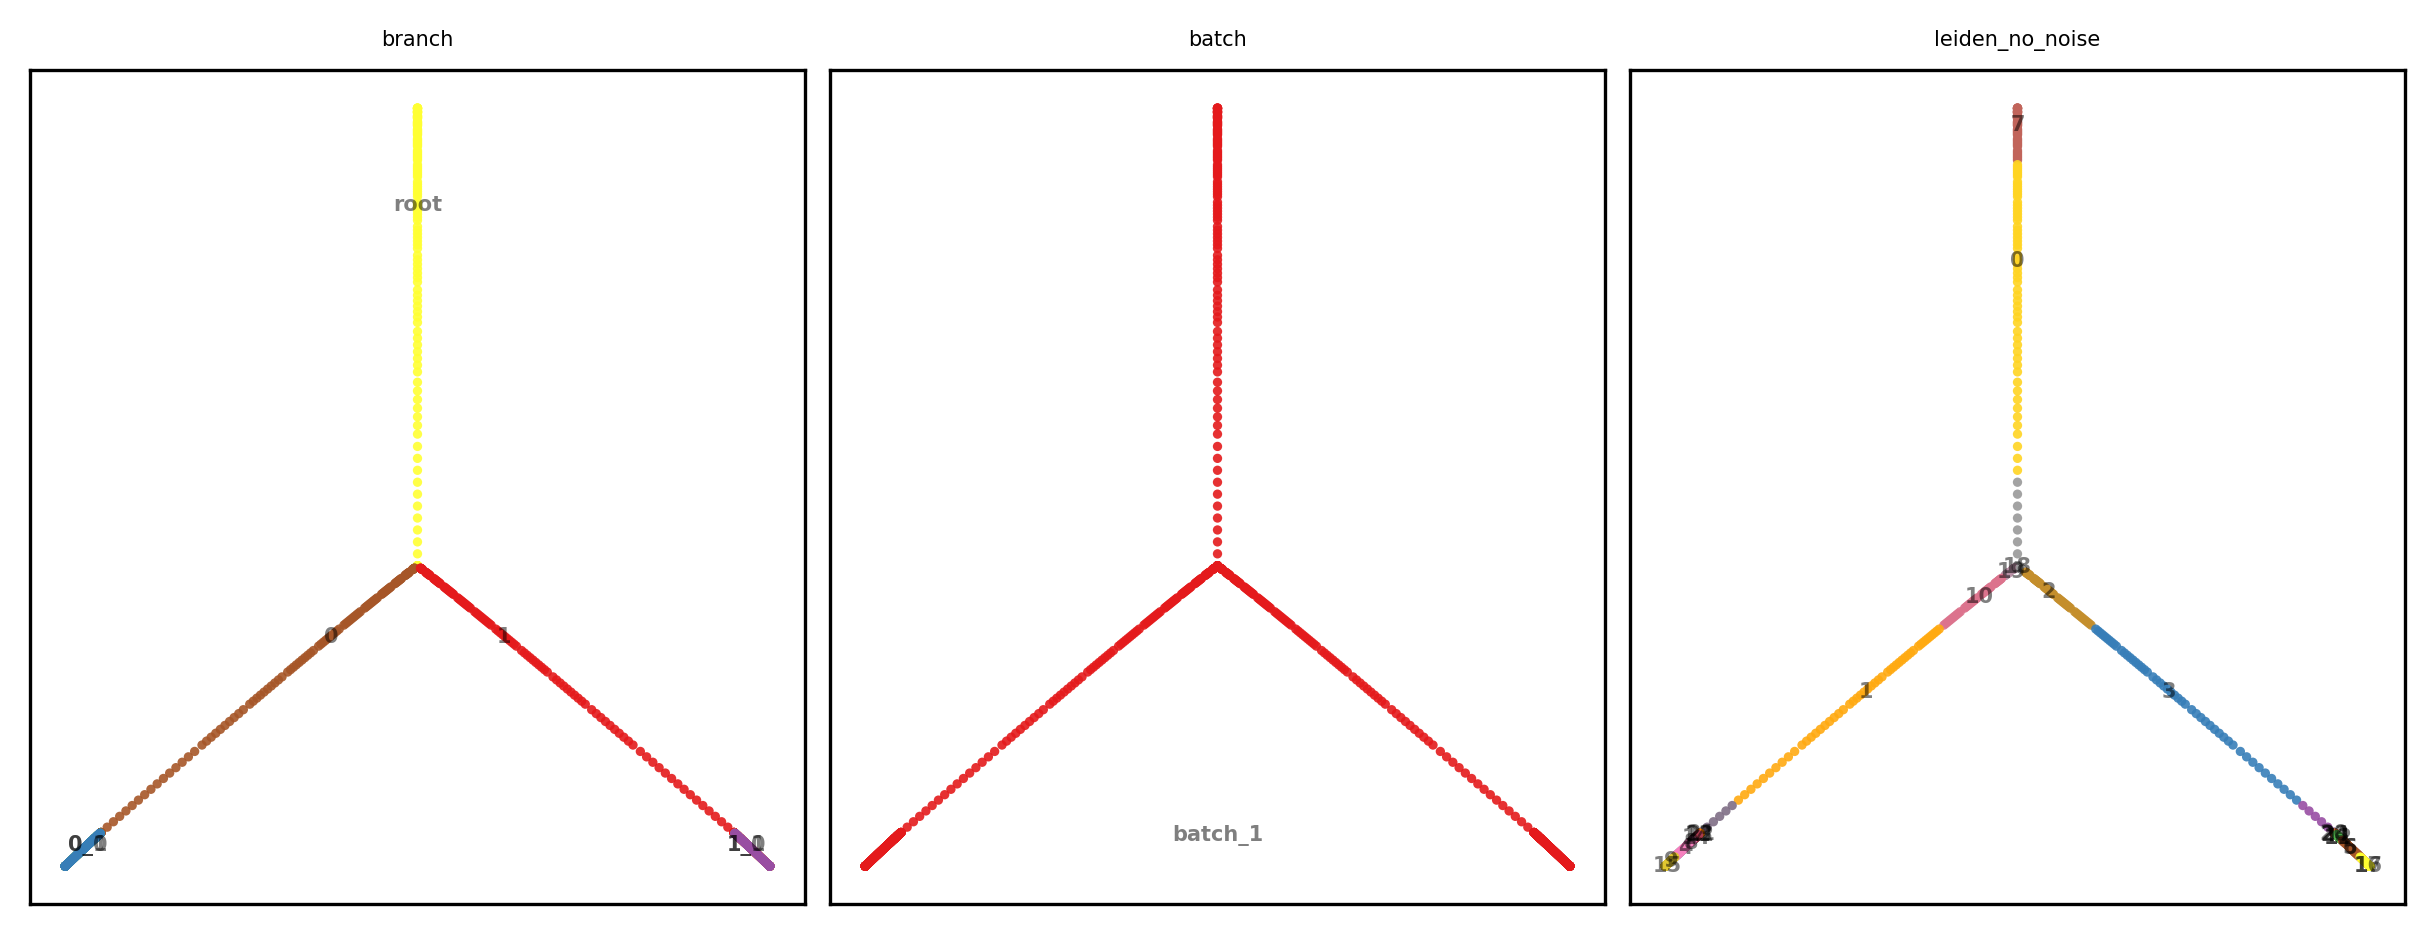

In [10]:
show_basis = 'PCA_no_noise'
show_cols = [state_key, batch_key, leiden_key]

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

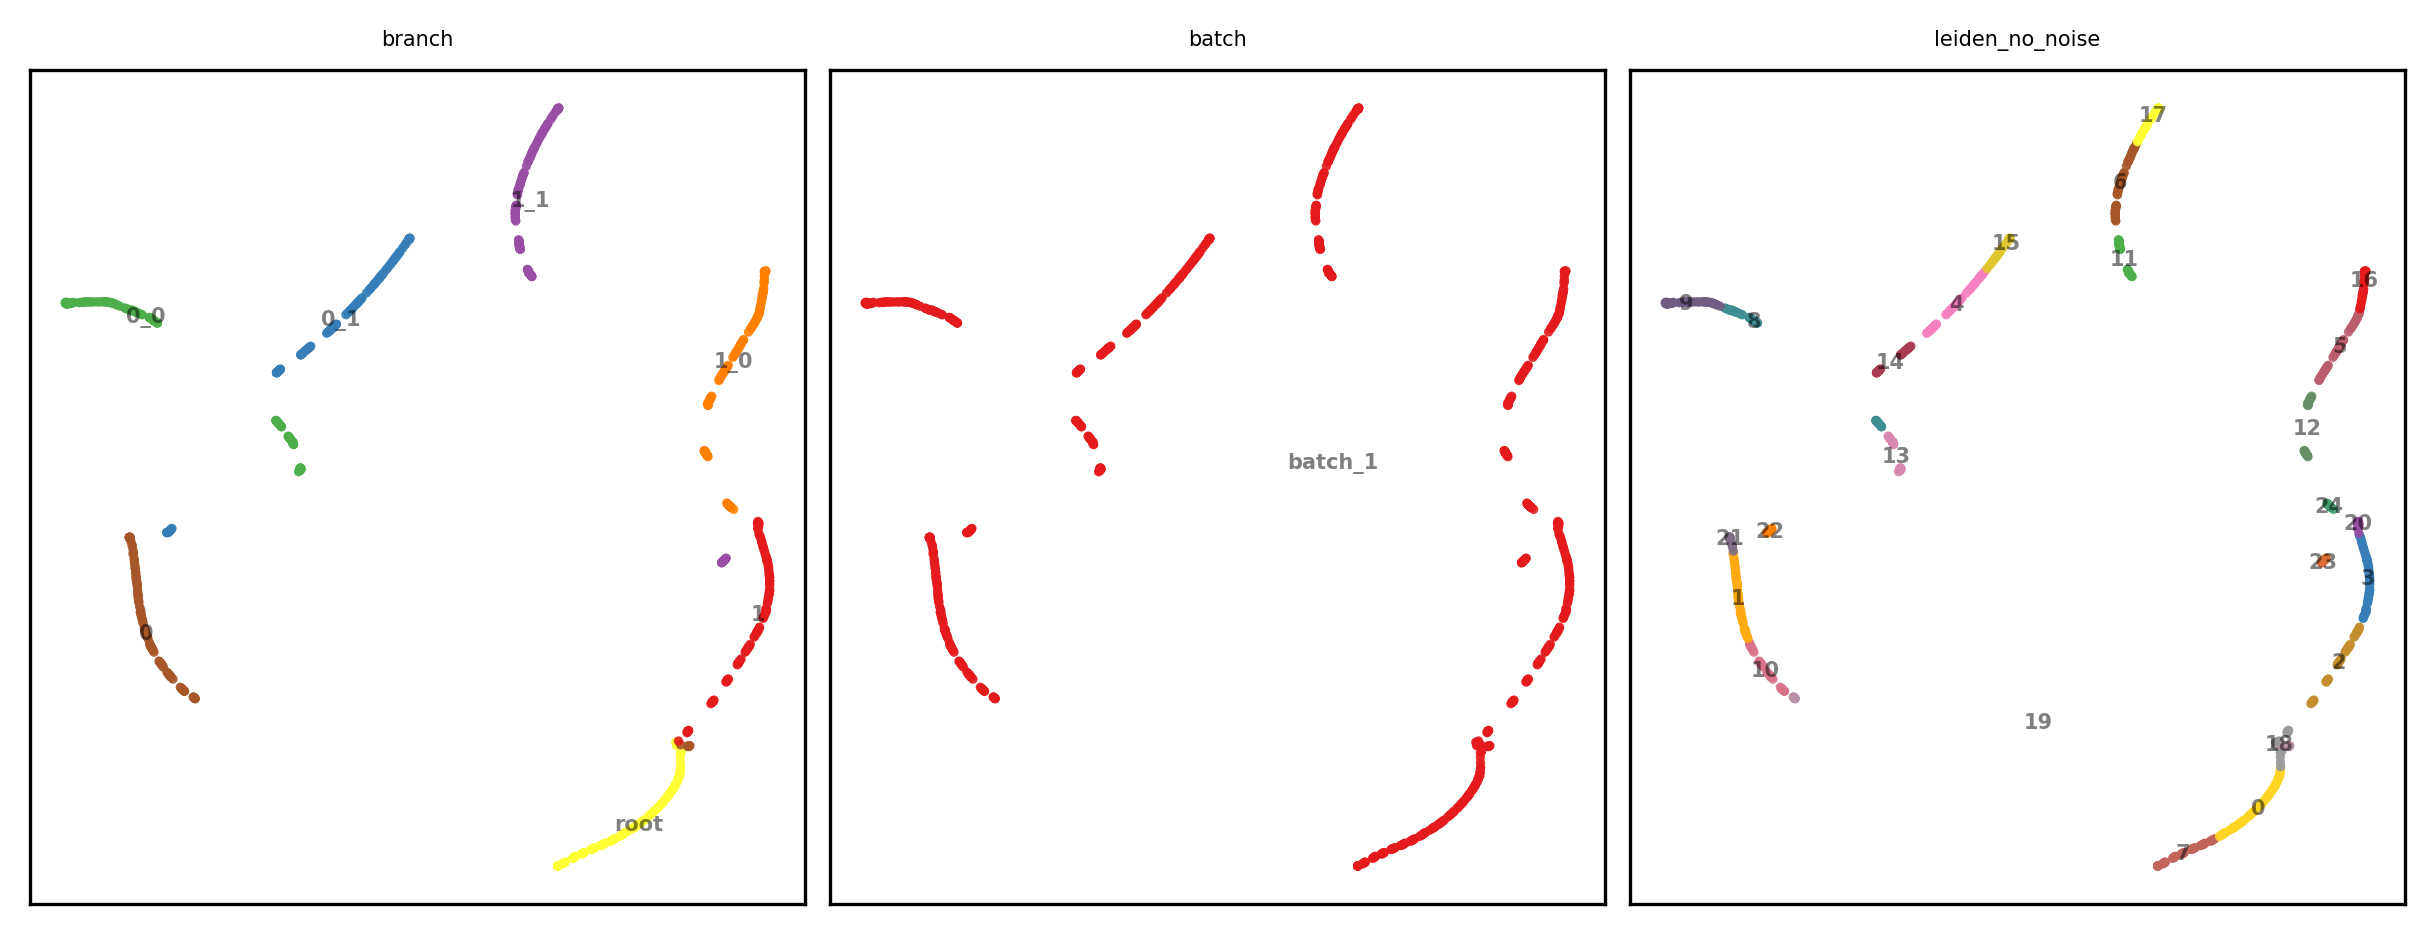

In [11]:
show_basis = 'UMAP_no_noise'

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

### noise added, Run all methods

In [12]:
run_methods = ["PCA", "UMAP", "t-SNE", "DiffusionMap", "NMF", 
             "FactorAnalysis", "FastICA", "LDA", "ZIFA", "scVI", "PHATE", 
             "Concord", "Concord-decoder"]
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]
combined_keys

['no_noise',
 'wt_noise',
 'DiffusionMap',
 'NMF',
 'FactorAnalysis',
 'FastICA',
 'LDA',
 'ZIFA',
 'scVI',
 'PHATE',
 'Concord',
 'Concord-decoder']

In [17]:
time_log = ccd.ul.run_dimensionality_reduction_pipeline(
    adata,
    source_key="X",
    methods=run_methods,
    n_components=15,
    random_state=seed,
    device=device,
    save_dir=save_dir,
    concord_epochs=20,
    concord_min_pid=0.95
)

Running zero-inflated factor analysis with N = 896, D = 72, K = 15
Param change below threshold 1.000e-02 after 9 iterations


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|██████████| 400/400 [00:41<00:00, 11.04it/s, v_num=1, train_loss_step=92.7, train_loss_epoch=90]  

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:41<00:00,  9.75it/s, v_num=1, train_loss_step=92.7, train_loss_epoch=90]
Calculating PHATE...
  Running PHATE on 896 observations and 72 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.06 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating optimal t...
    Automatically selected t = 14
  Calculated optimal t in 0.42 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.20 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.64 seconds.
Calculated PHATE in 1.34 seconds.
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.dataloader - WARNING - Only one domai

WARNING clustering 896 points to 29 centroids: please provide at least 1131 training points


p_intra_knn: 0.3


Epoch 0 Training: 14it [00:00, 112.63it/s, loss=4.35]
Epoch 19 Training: 100%|██████████| 14/14 [00:00<00:00, 114.00it/s, loss=3.85]


Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.


WARNING clustering 896 points to 29 centroids: please provide at least 1131 training points


p_intra_knn: 0.3


Epoch 0 Training: 14it [00:00, 96.77it/s, loss=17.9]
Epoch 19 Training: 100%|██████████| 14/14 [00:00<00:00, 96.81it/s, loss=8.89]


In [18]:
# Run umap and PCA for all latent embeddings
adata.obsm['no_noise'] = adata.layers['no_noise']
adata.obsm['wt_noise'] = adata.layers['wt_noise']
max_pc = 15
for basis in combined_keys:
    print("Running UMAP and PCA for", basis)
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
    if not any(substring in basis for substring in ['PHATE', 'PCA']):
        if basis in adata.layers.keys():
            n_pc = min(min(adata.layers[basis].shape[1], adata.shape[0]) - 1, max_pc)
        else:
            n_pc = min(min(adata.obsm[basis].shape[1], adata.shape[0]) - 1, max_pc)
        
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=n_pc, random_state=seed)


Running UMAP and PCA for no_noise
Running UMAP and PCA for wt_noise
Running UMAP and PCA for DiffusionMap
Running UMAP and PCA for NMF
Running UMAP and PCA for FactorAnalysis
Epoch 88/400:  22%|██▏       | 87/400 [02:25<08:42,  1.67s/it, v_num=1, train_loss_step=112, train_loss_epoch=103]
Running UMAP and PCA for FastICA
Running UMAP and PCA for LDA
Running UMAP and PCA for ZIFA
Running UMAP and PCA for scVI
Running UMAP and PCA for PHATE
Running UMAP and PCA for Concord
Running UMAP and PCA for Concord-decoder


Plotting  embeddings
Coloring by time


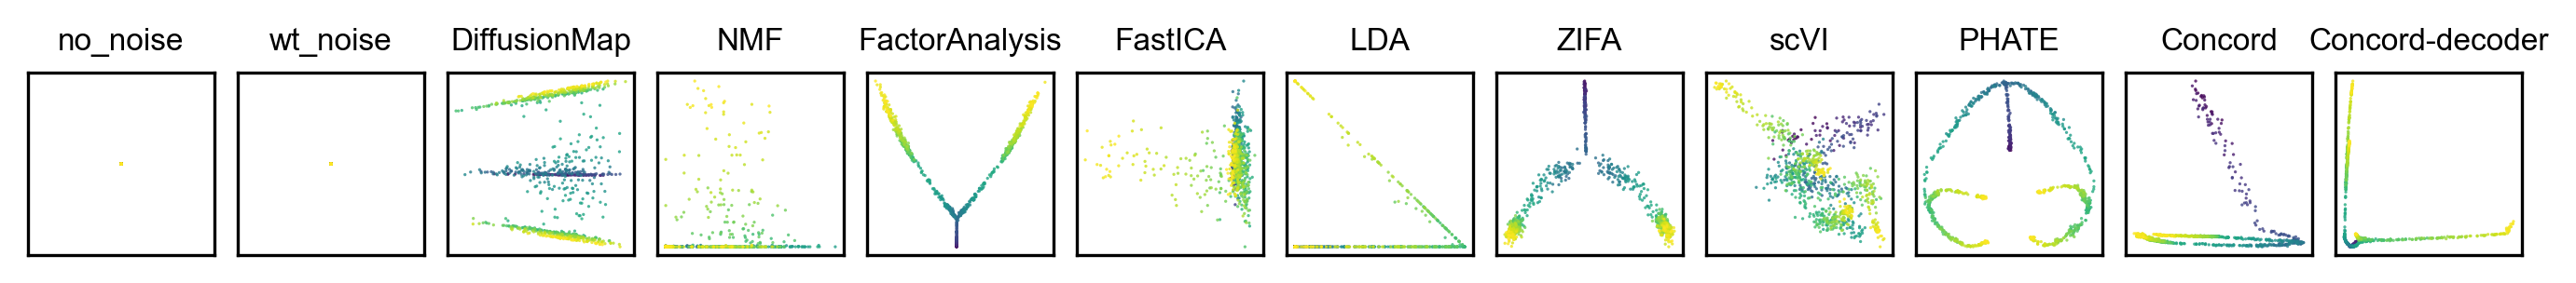

Plotting PAGA embeddings
Coloring by time


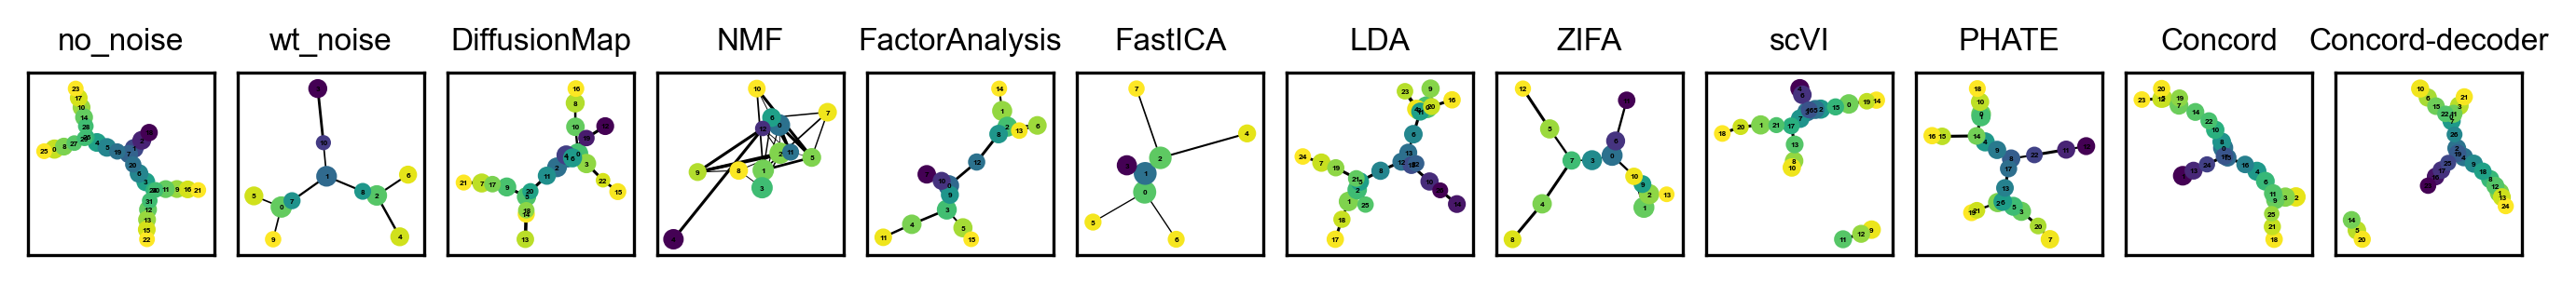

Plotting KNN embeddings
Coloring by time


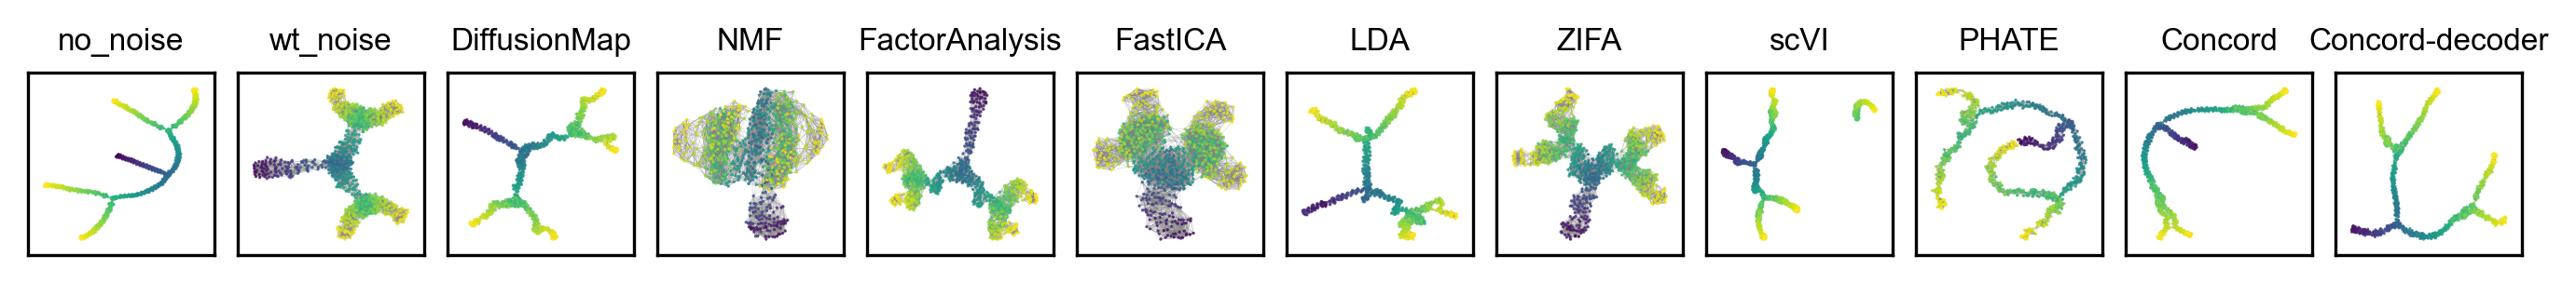

Plotting PCA embeddings
Coloring by time


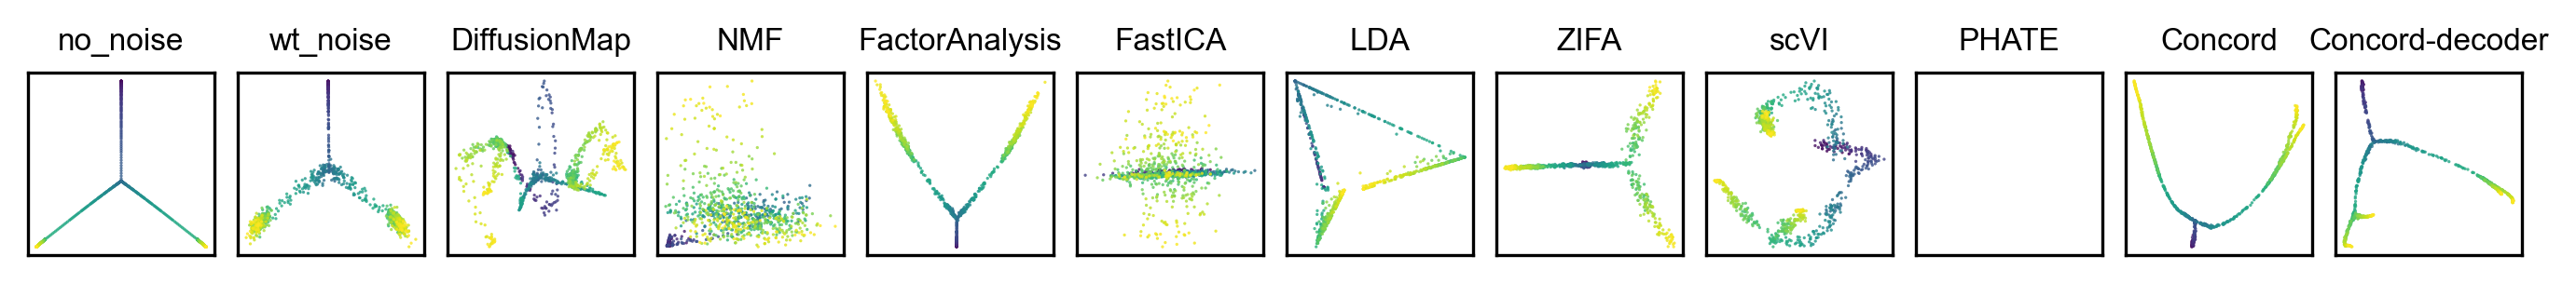

Plotting UMAP embeddings
Coloring by time


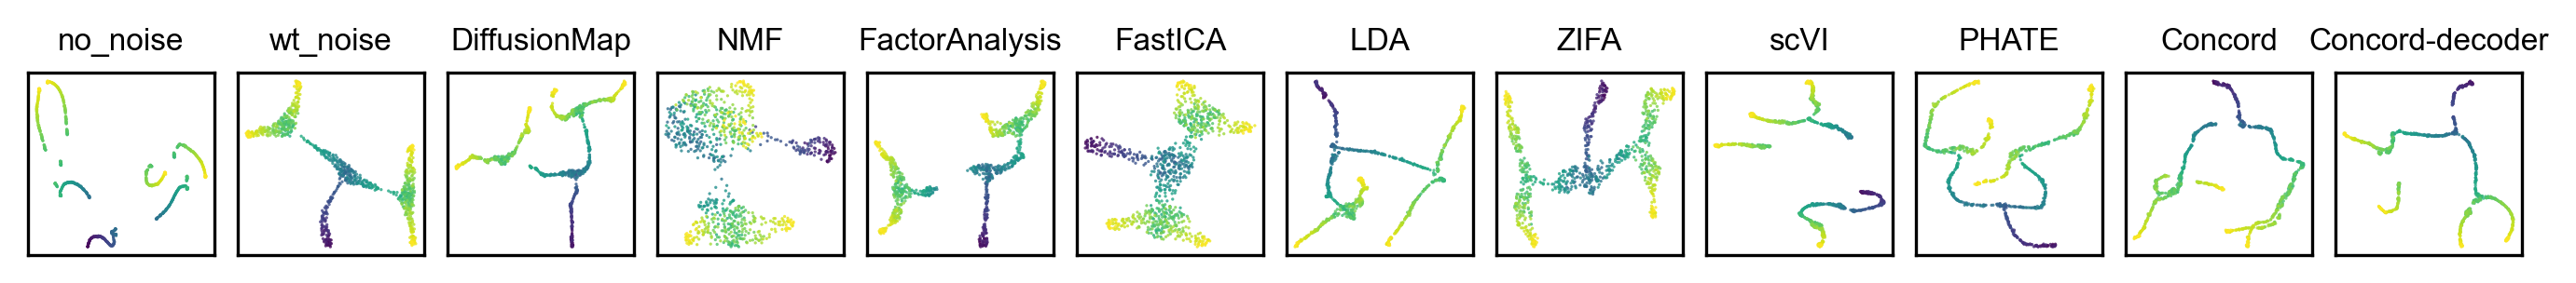

In [20]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = ['time']
basis_types = ['', 'PAGA', 'KNN', 'PCA', 'UMAP']

font_size=8
point_size=2.5
alpha=0.8
figsize=(9,0.9)
ncols = 12
nrows = int(np.ceil(len(combined_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1'}
k=15
edges_color='grey'
edges_width=0.05
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        combined_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix,
        save_format='svg'
    )


In [23]:
# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord', path=batch_indices, sigma=2)
adata.obsm['Concord_sorted'] = adata.obsm['Concord'][:, feature_order]

_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord-decoder', path=batch_indices, sigma=2)
adata.obsm['Concord-decoder_sorted'] = adata.obsm['Concord-decoder'][:, feature_order]

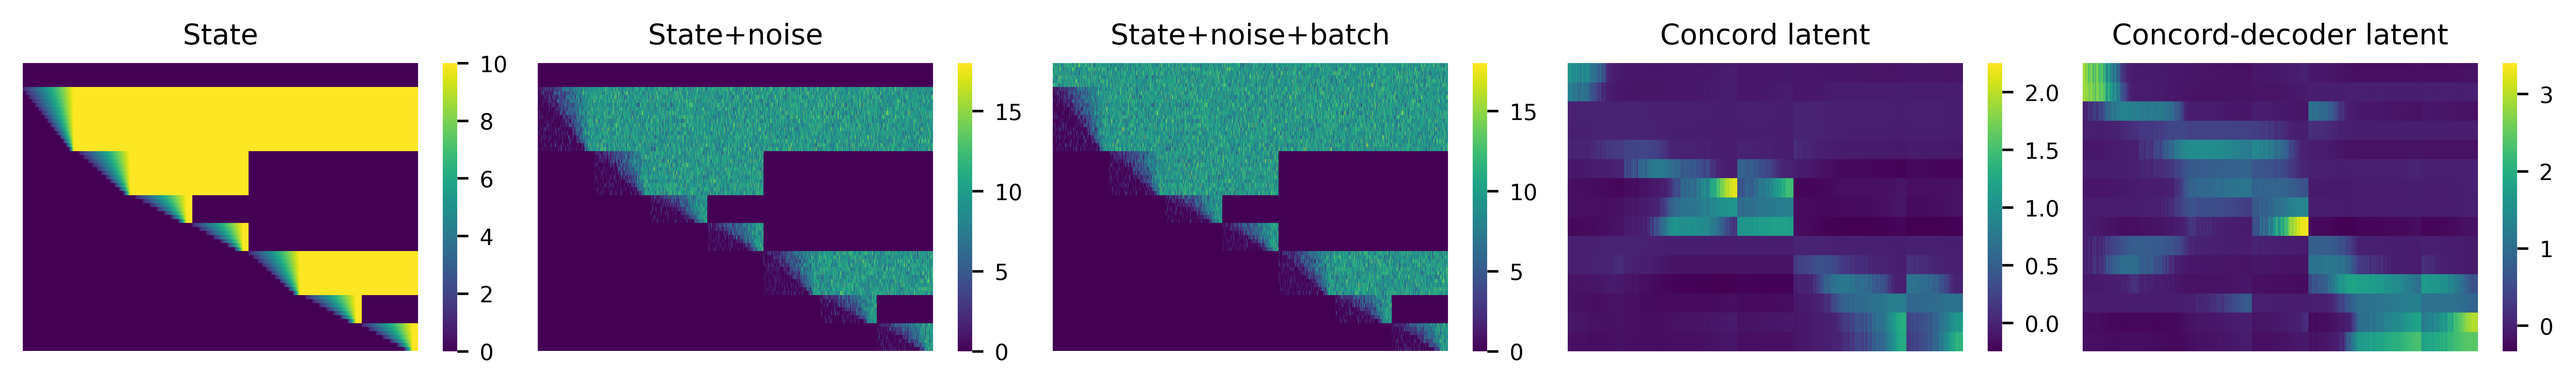

In [24]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord-decoder_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord-decoder latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

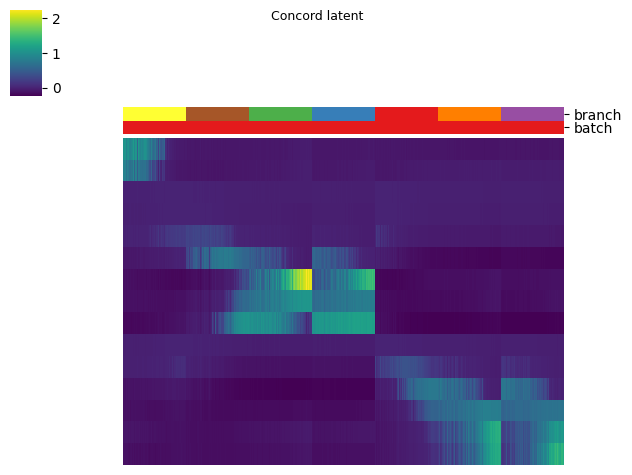

In [25]:
ccd.pl.heatmap_with_annotations(adata, val='Concord_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=True, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=f"heatmap_wt_annot_{file_suffix}.svg", figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)

In [26]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad")
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad")
file_suffix

'Dec14-1907'

# Evaluation

In [5]:
adata = sc.read(data_dir / f"adata_Dec14-1907.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Dec14-1907.h5ad")

### Topology

Run topological analysis pipeline:

In [27]:
run_methods = ["PCA", "UMAP", "t-SNE", "DiffusionMap", "NMF", 
             "FactorAnalysis", "FastICA", "LDA", "ZIFA", "scVI", "PHATE", 
             "Concord", "Concord-decoder"]
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise_PCA', 'wt_noise_PCA'] + [key for key in run_methods if key not in exclude_keys]
combined_keys

['no_noise_PCA',
 'wt_noise_PCA',
 'DiffusionMap',
 'NMF',
 'FactorAnalysis',
 'FastICA',
 'LDA',
 'ZIFA',
 'scVI',
 'PHATE',
 'Concord',
 'Concord-decoder']

In [28]:
homology_dimensions = [0,1,2]
diagrams = {}
for key in combined_keys:
    print(f"Computing persistent homology for {key}")
    diagrams[key] =  ccd.ul.compute_persistent_homology(adata, key=key, homology_dimensions=homology_dimensions)

import pickle
with open(save_dir / f"topology_diagrams_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(diagrams, f)

Computing persistent homology for no_noise_PCA
Computing persistent homology for wt_noise_PCA
Computing persistent homology for DiffusionMap
Computing persistent homology for NMF
Computing persistent homology for FactorAnalysis
Computing persistent homology for FastICA
Computing persistent homology for LDA
Computing persistent homology for ZIFA
Computing persistent homology for scVI
Computing persistent homology for PHATE
Computing persistent homology for Concord
Computing persistent homology for Concord-decoder


In [29]:
save_dir / f"topology_diagrams_{file_suffix}.pkl"

PosixPath('../save/dev_simulation_tree_singlebatch-Dec14/topology_diagrams_Dec14-1907.pkl')

In [ ]:
import pickle
with open(Path('../save/dev_simulation_oneloop_singlebatch-Dec14/topology_diagrams_Dec14-1907.pkl'), 'rb') as f:
    diagrams = pickle.load(f)

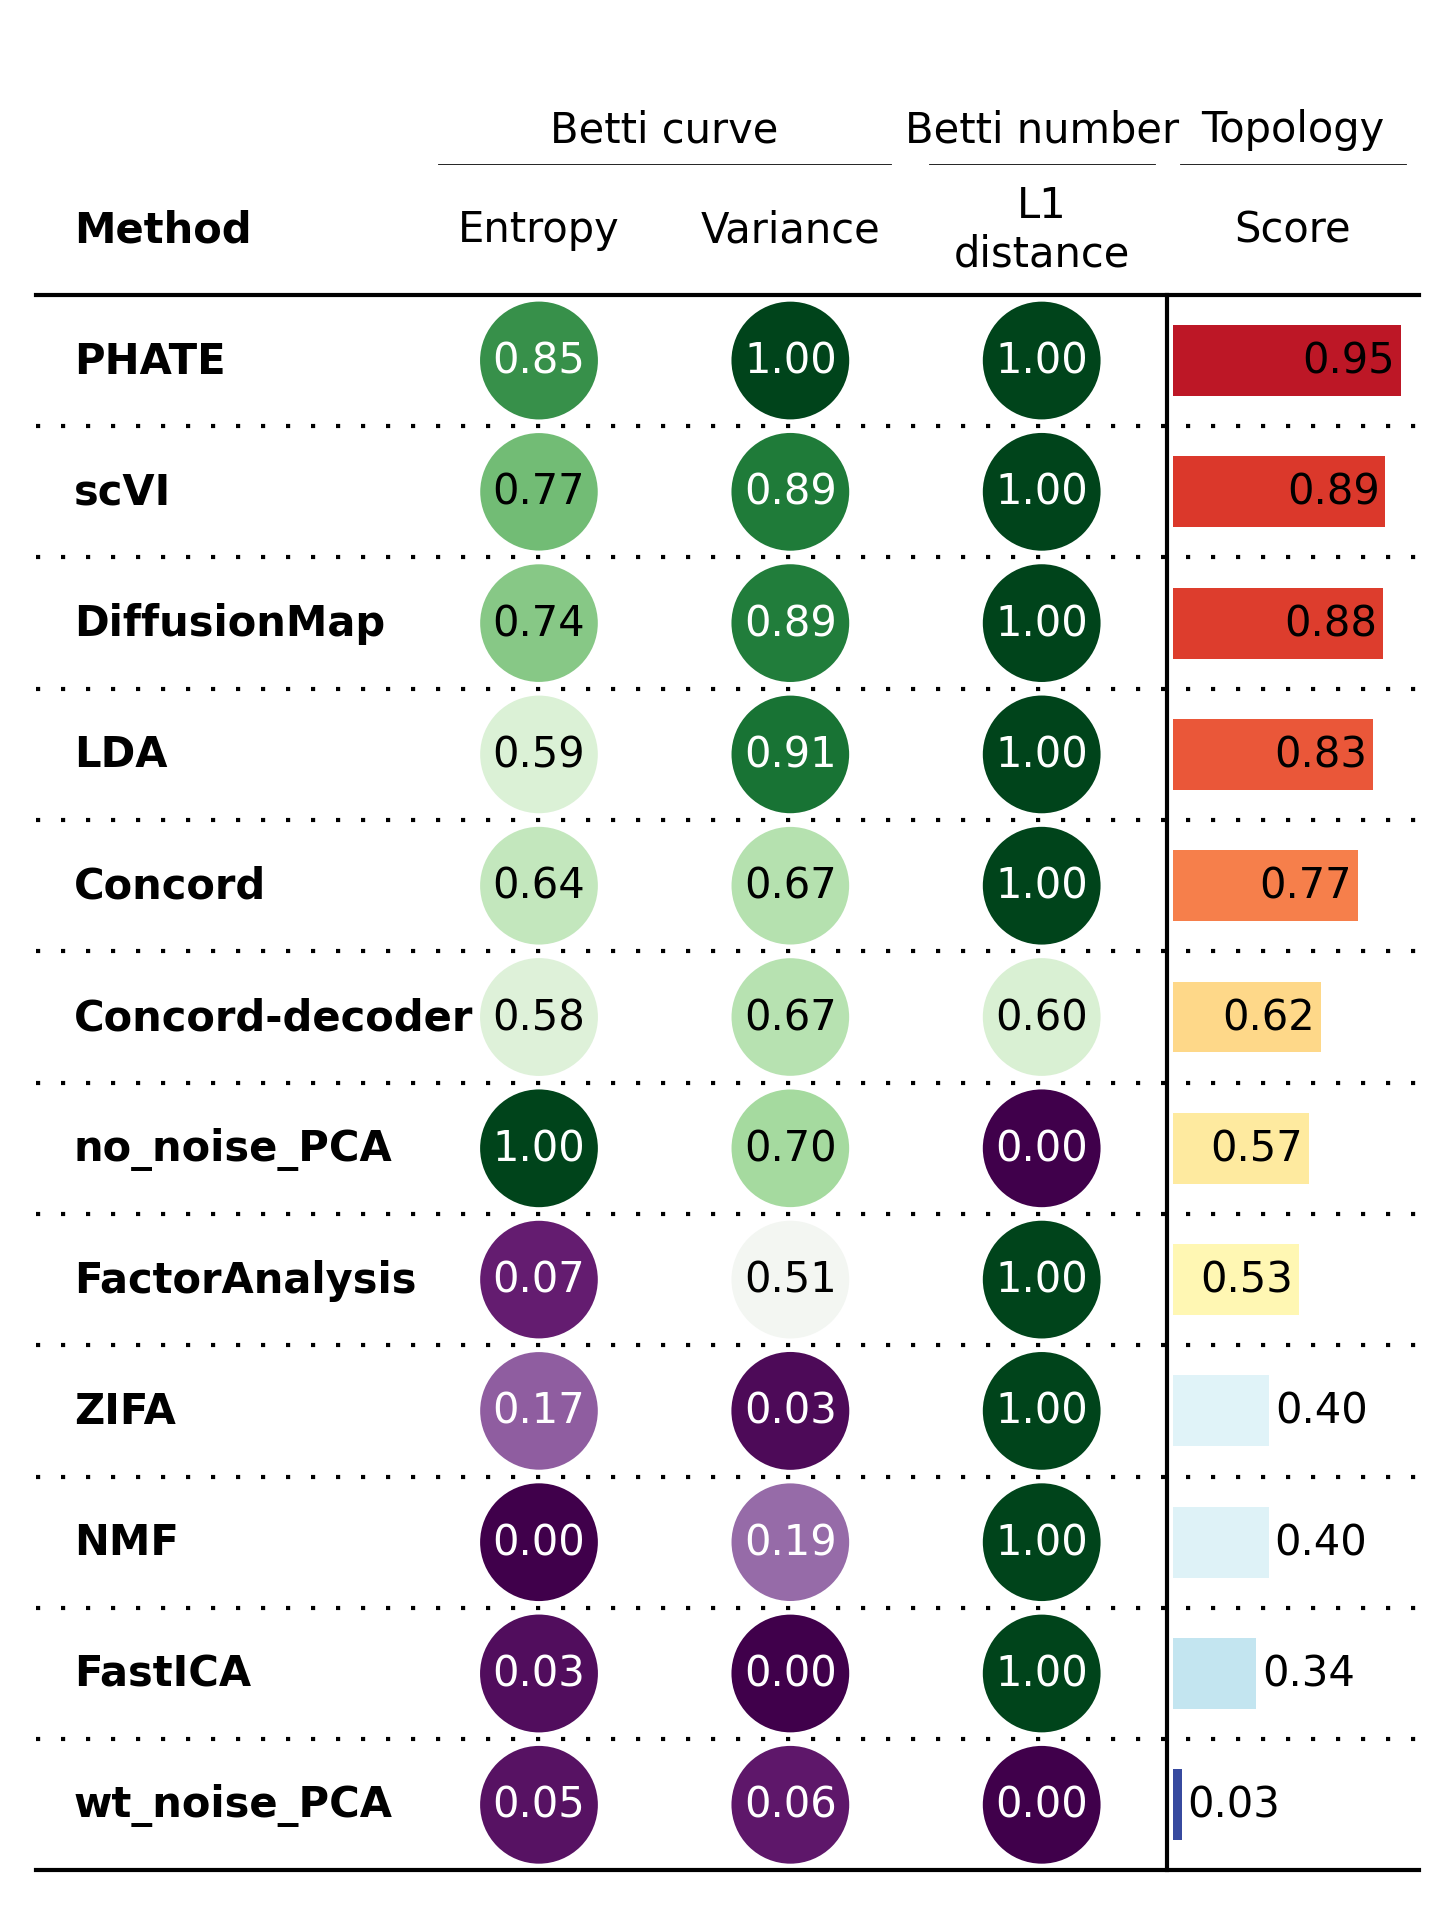

In [30]:
topology_results = ccd.ul.benchmark_topology(diagrams, expected_betti_numbers=[0,0,0], save_dir=save_dir, file_suffix=file_suffix)
max_betti = 5
topology_metrics = topology_results['combined_metrics']#.drop(index=['no_noise_PCA', 'wt_noise_PCA'])
topology_metrics[('Betti number', 'L1 distance')] = topology_metrics[('Betti number', 'L1 distance')].clip(upper=5)
agg_name1 = 'Topology'
agg_name2 = 'Score'
topology_scores = ccd.ul.benchmark_stats_to_score(topology_metrics, min_max_scale=True, one_minus=True, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(topology_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"topology_results_{file_suffix}.pdf", figsize=(6, 8), dpi=300)

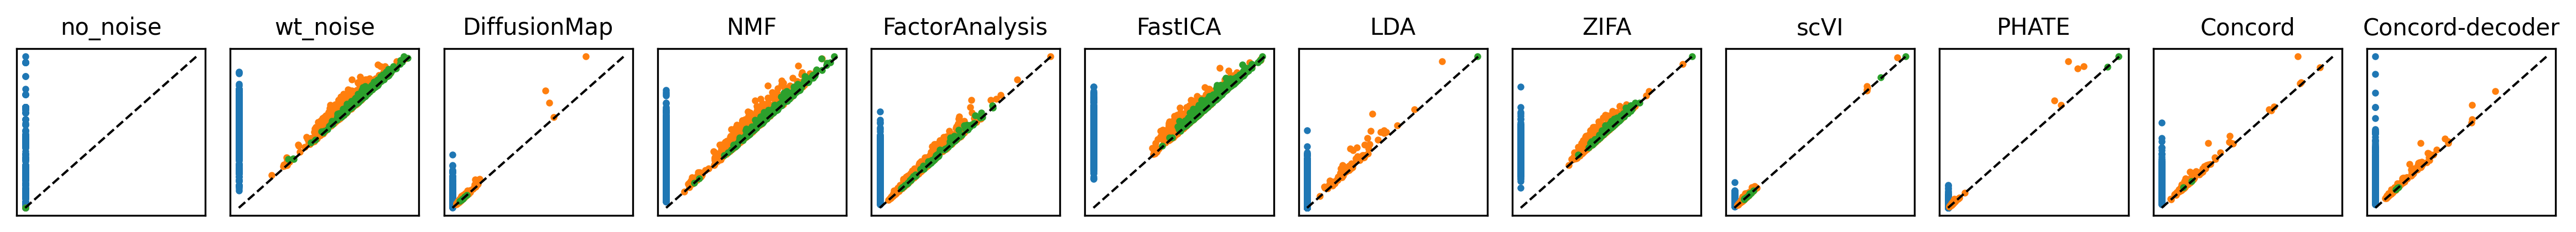

In [31]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys}
# Change the key names to remove 'PCA_'
diagrams_ordered = {key.replace('_PCA', ''): diagrams_ordered[key] for key in diagrams_ordered}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=12, fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.pdf", legend=False, label_axes=False, axis_ticks=False)

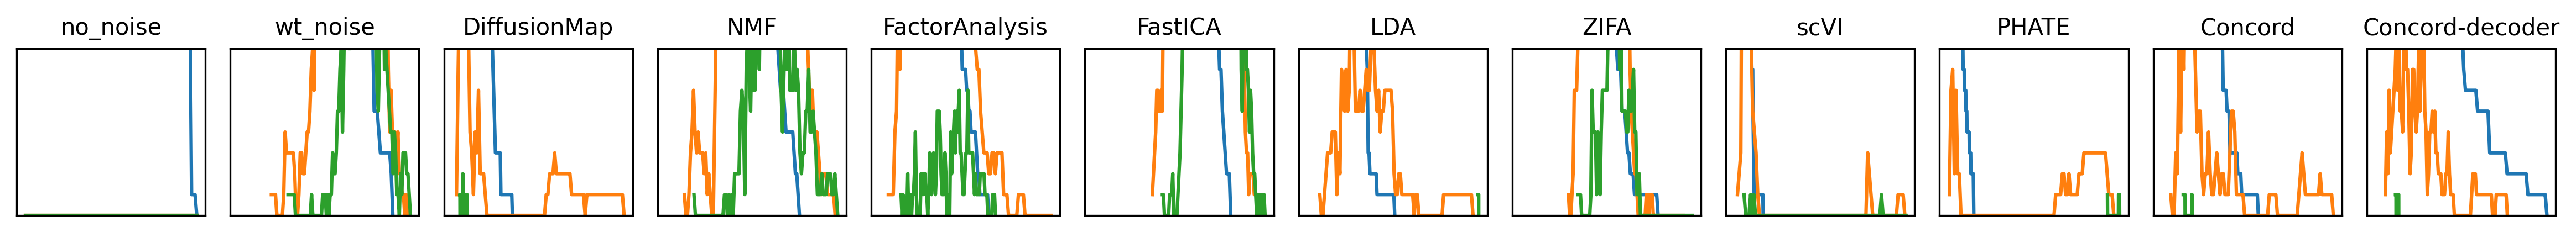

In [32]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=12, fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

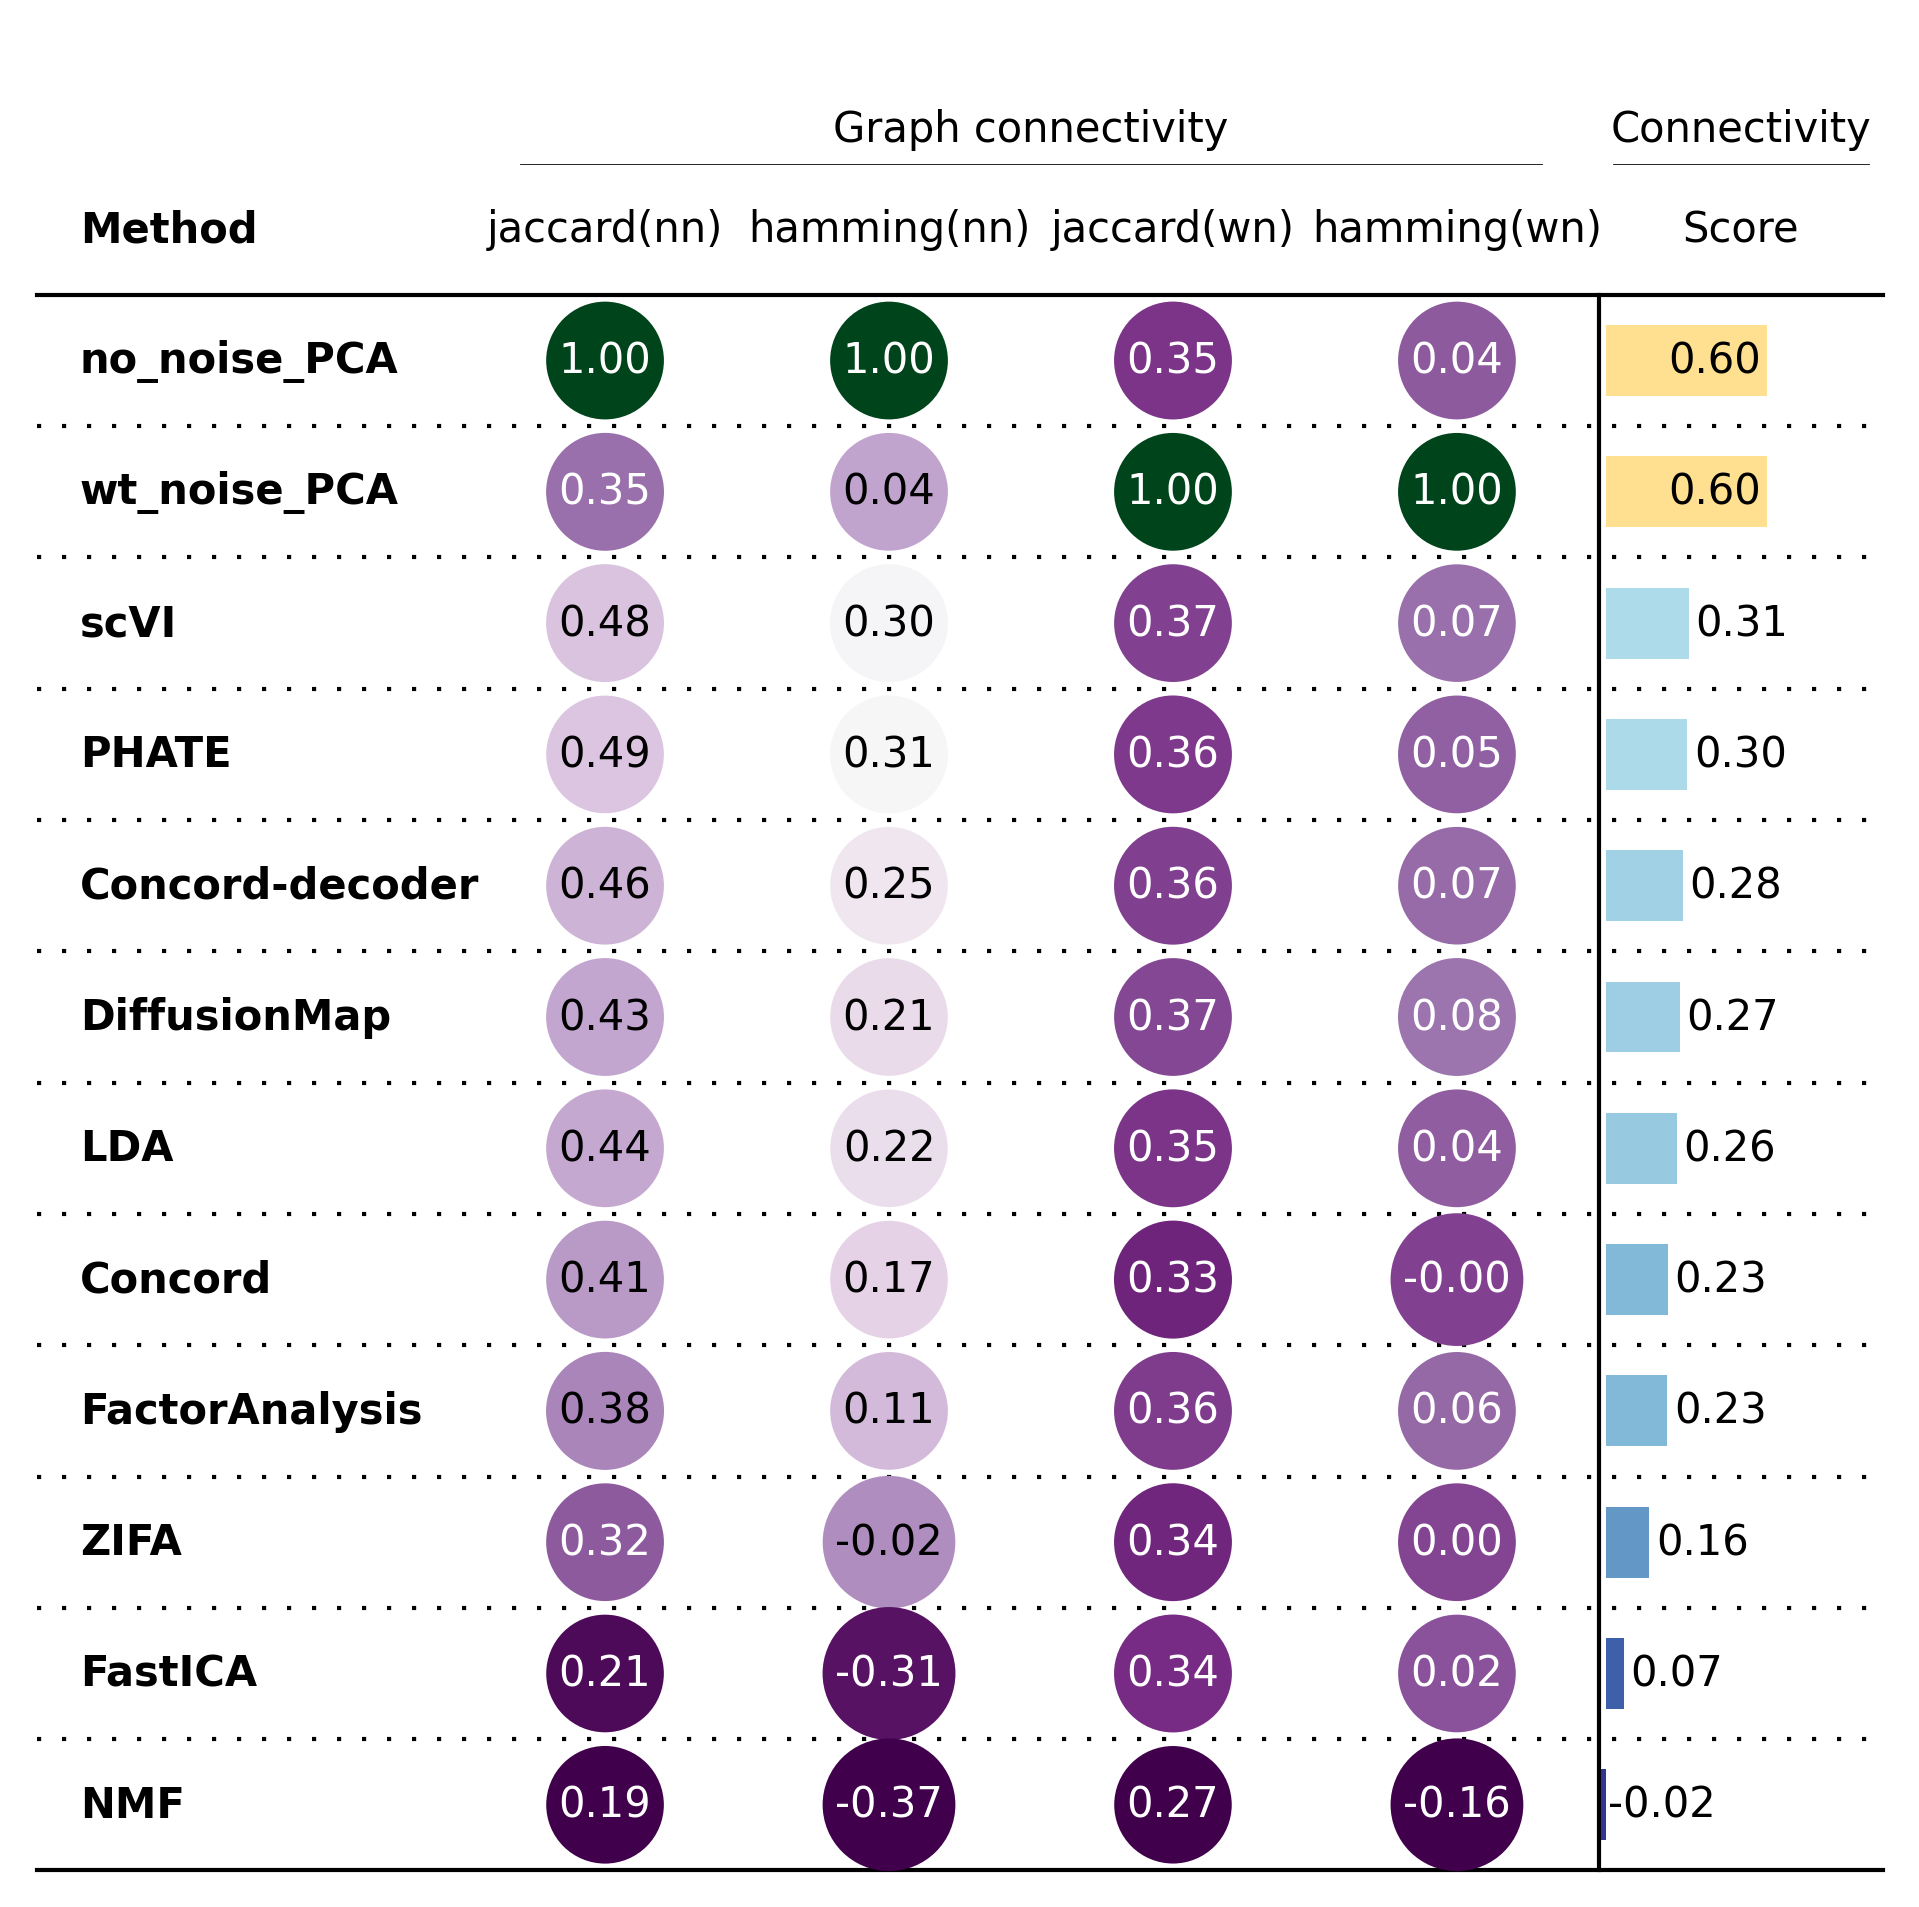

In [33]:
# compare connectivity for latent vs ground truth, store the result in a pandas dataframe
groundtruth_keys = {'(nn)': 'no_noise_PCA','(wn)': 'wt_noise_PCA'}
connectivity_df = ccd.ul.benchmark_graph_connectivity(adata, emb_keys=combined_keys, groundtruth_keys=groundtruth_keys, k=30)
agg_name1 = 'Connectivity'
agg_name2 = 'Score'
connectivity_scores = ccd.ul.benchmark_stats_to_score(connectivity_df, min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(connectivity_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"connectivity_results_{file_suffix}.pdf", figsize=(8, 8), dpi=300)


# Geomtric Features 

### Integrated benchmark pipeline

In [40]:
geometry_metrics = ['cell_distance_corr', 'local_distal_corr', 'trustworthiness', 'state_distance_corr', 'state_dispersion_corr']
dist_metric = 'cosine'
corr_types = ['pearsonr', 'spearmanr', 'kendalltau']
groundtruth_key = 'wt_noise_PCA'
groundtruth_key = 'no_noise_PCA'
# Convert state_dispersion to a dict of groundtruth dispersion
#groundtruth_dispersion = {'cluster_' + str(i): state_dispersion[i]**2 for i in range(5)} # convert to variance
geometry_df, geometry_full = ccd.ul.benchmark_geometry(adata, keys=combined_keys, eval_metrics=geometry_metrics, 
                                      dist_metric=dist_metric,
                                      corr_types = corr_types,
                                      groundtruth_key = groundtruth_key,
                                      state_key = leiden_key,
                                      batch_key = batch_key,
                                      #groundtruth_dispersion = groundtruth_dispersion,
                                      dispersion_metric='var',
                                      return_type='full',
                                      start_point=0,
                                      end_point=adata.n_obs-1,
                                      pseudotime_k = 30,
                                      truetime_key = 'time',
                                      save_dir=save_dir, 
                                      file_suffix=file_suffix)

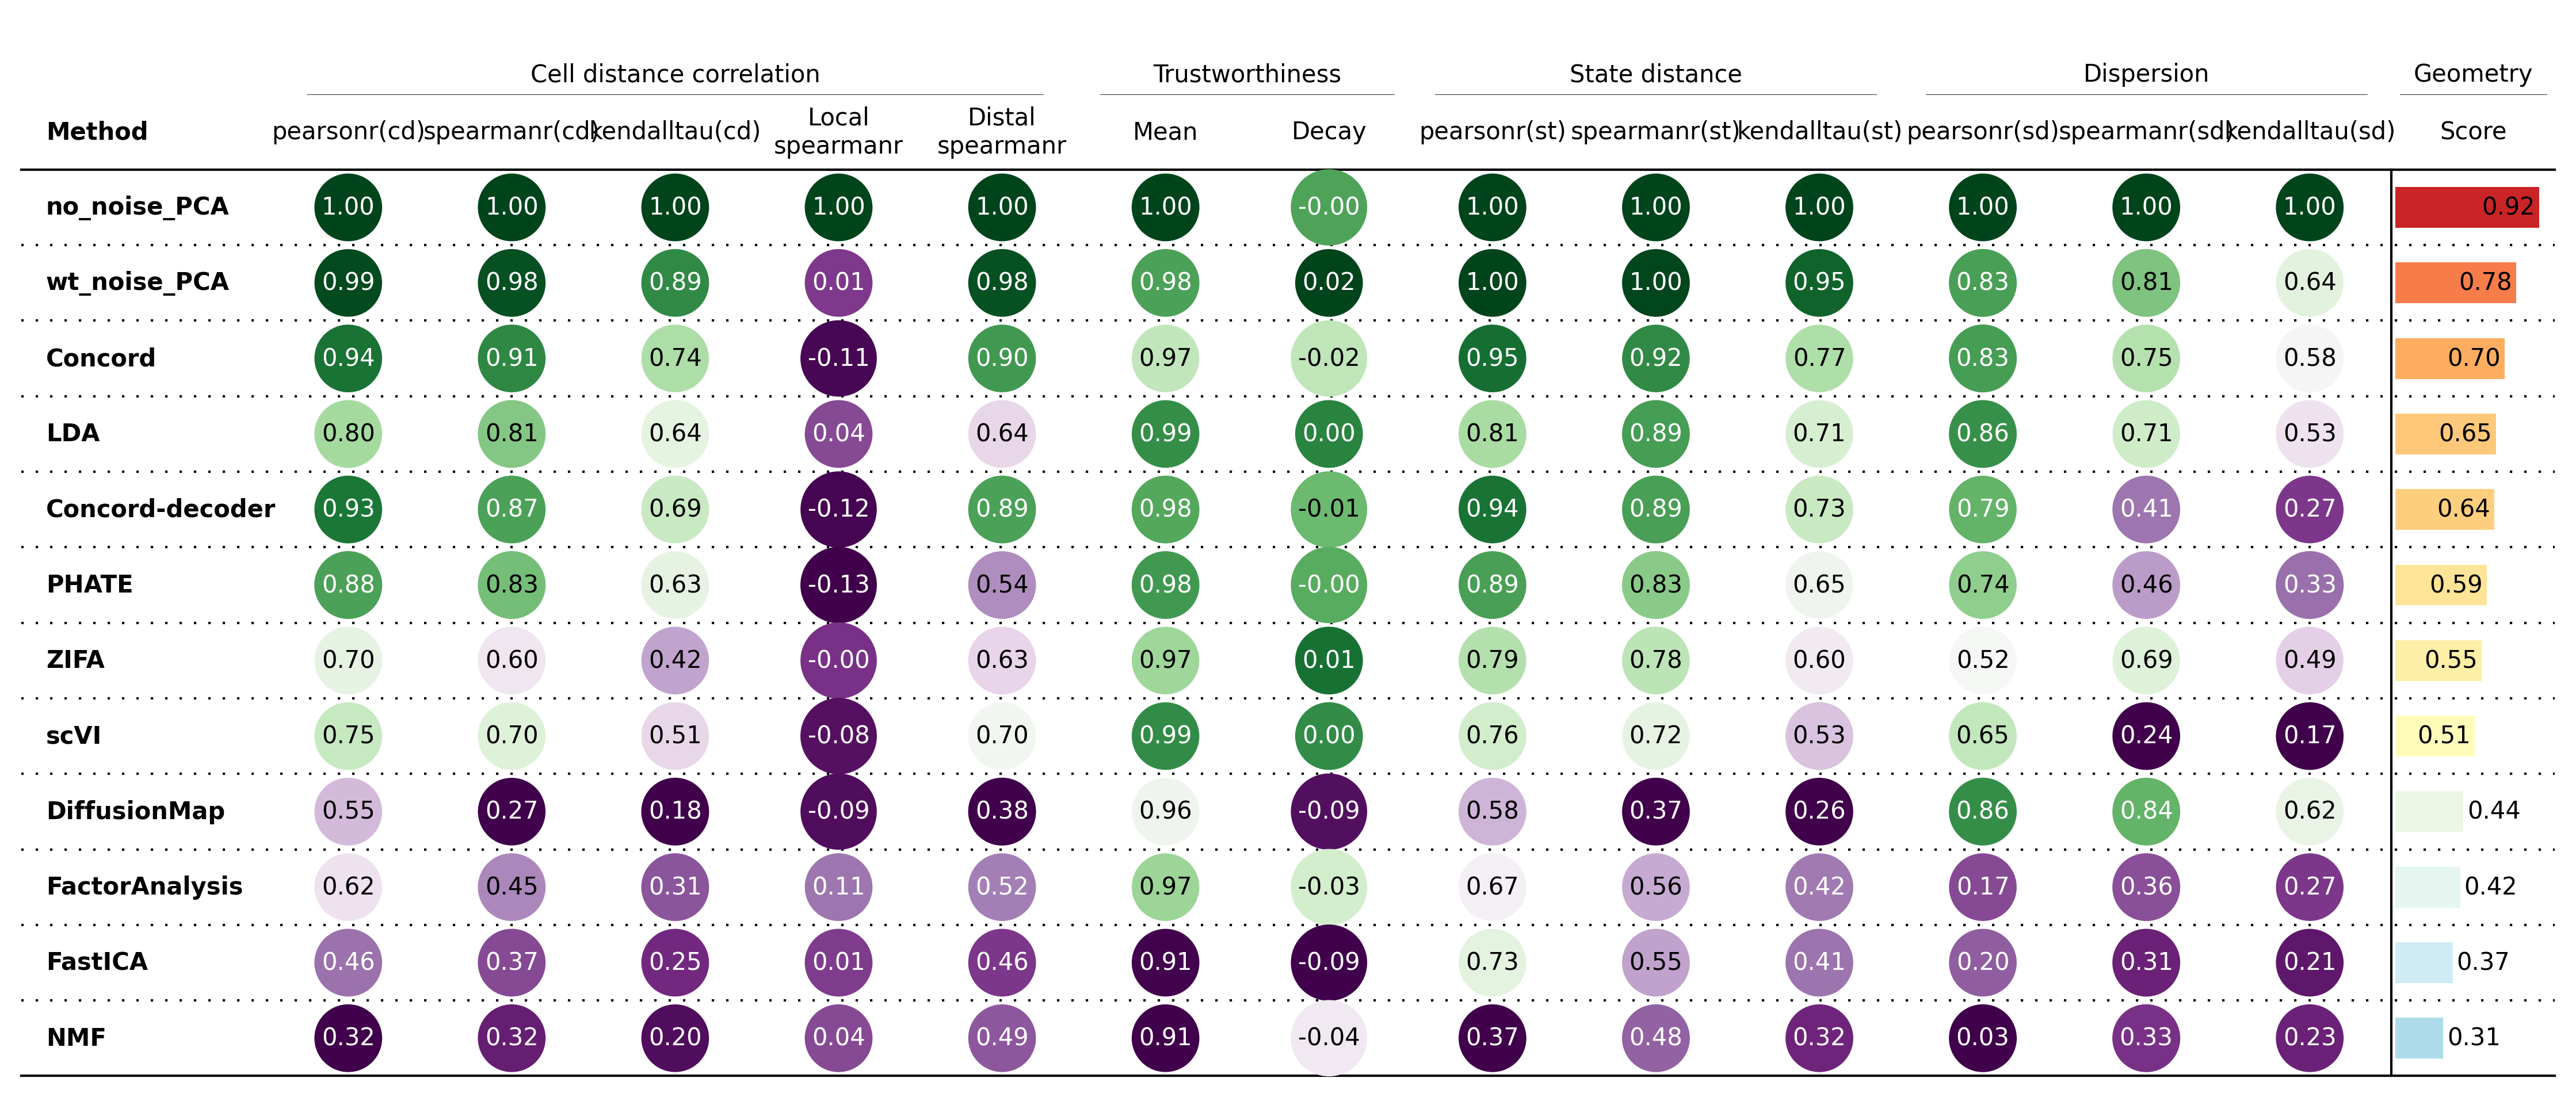

In [41]:
agg_name1 = 'Geometry'
agg_name2 = 'Score'
geometry_scores = ccd.ul.benchmark_stats_to_score(
    geometry_df, fillna = 0,               
    min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2))
ccd.pl.plot_benchmark_table(geometry_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"geometry_results_noscale_{dist_metric}_{groundtruth_key}_{file_suffix}.pdf", figsize=(19, 8), dpi=300)

In [42]:
geometry_full['Pseudotime']['pseudotime'].keys()

KeyError: 'Pseudotime'

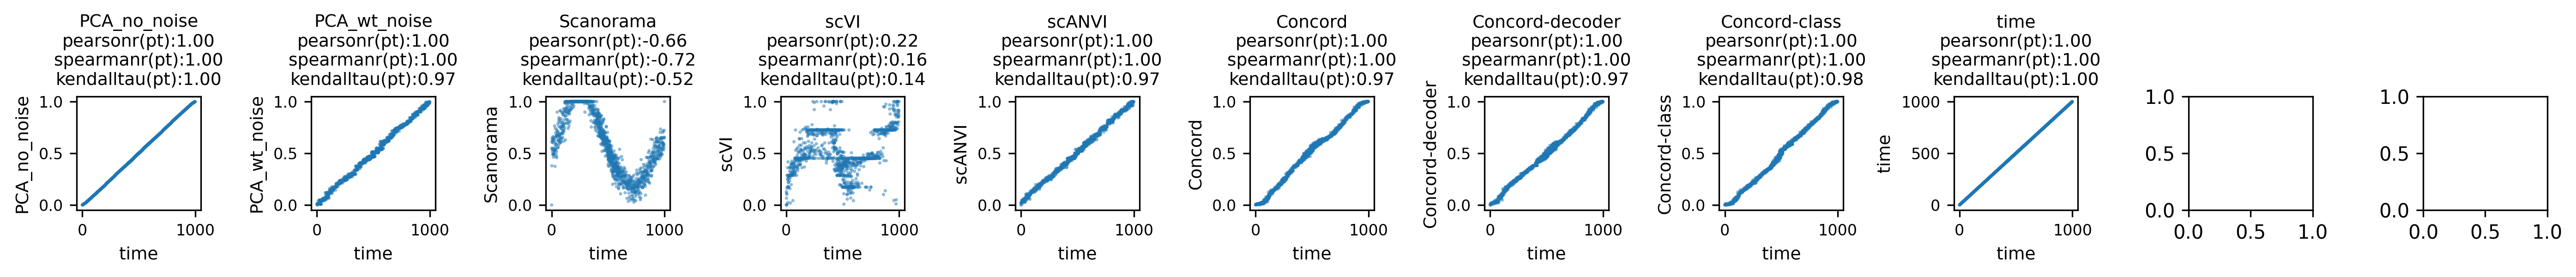

In [30]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['Pseudotime']['pseudotime'], 
    correlation= geometry_full['Pseudotime']['correlation'],
    s=3,
    ground_key = 'time', fontsize=9,
    n_cols = 11, figsize=(1.7,2.1), dpi=300, save_path=save_dir / f"pseudotime_scatter_{groundtruth_key}_{file_suffix}.pdf")

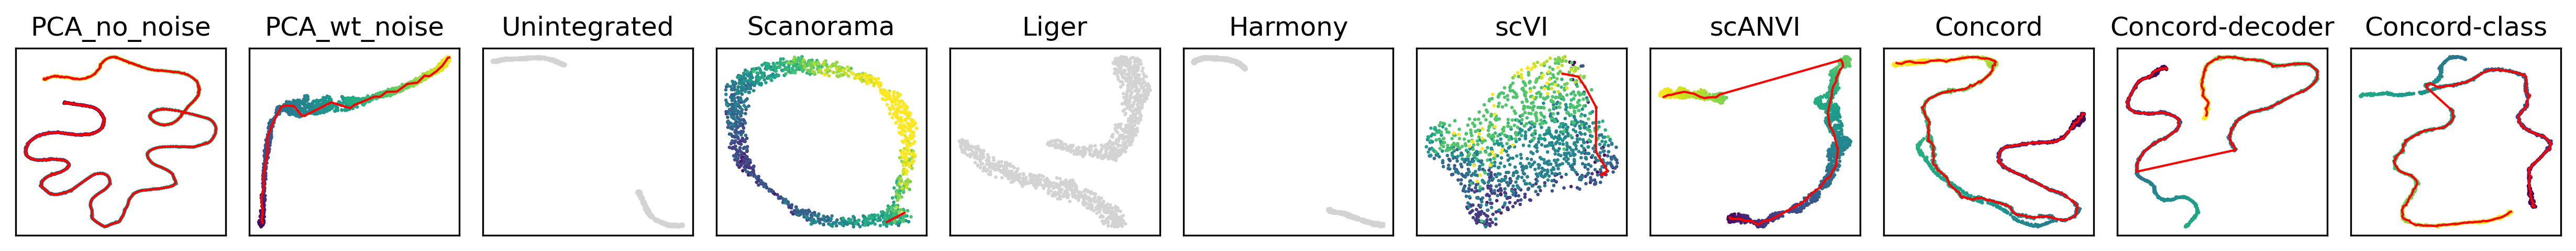

In [32]:
import matplotlib.pyplot as plt

n_cols = 11
n_rows = int(np.ceil(len(combined_keys) / n_cols))
base_size = (1.5, 1.7)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*base_size[0], n_rows*base_size[1]), dpi=300)

axes = np.atleast_2d(axes).flatten()
for basis in combined_keys:
    show_basis = basis + '_UMAP'
    if show_basis not in adata.obsm or basis not in geometry_full['Pseudotime']['pseudotime']:
        show_indices = None
        adata.obs['pseudotime_plot'] = np.nan
    else:
        show_indices = geometry_full['Pseudotime']['path'][basis]
        adata.obs['pseudotime_plot'] = geometry_full['Pseudotime']['pseudotime'][basis]
    
    show_cols = ['pseudotime_plot']

    ccd.pl.plot_embedding(
        adata, show_basis, show_cols, highlight_indices=show_indices, highlight_size=5, draw_path=True, alpha=1.0,
        font_size=12, point_size=10, path_width=1,
        legend_loc='on data', title=basis, colorbar_loc=None, rasterized=True, xlabel=None, ylabel=None, 
        ax=axes[combined_keys.index(basis)]
    )

plt.tight_layout()
plt.savefig(save_dir / f"pseudotime_embedding_{file_suffix}.pdf")

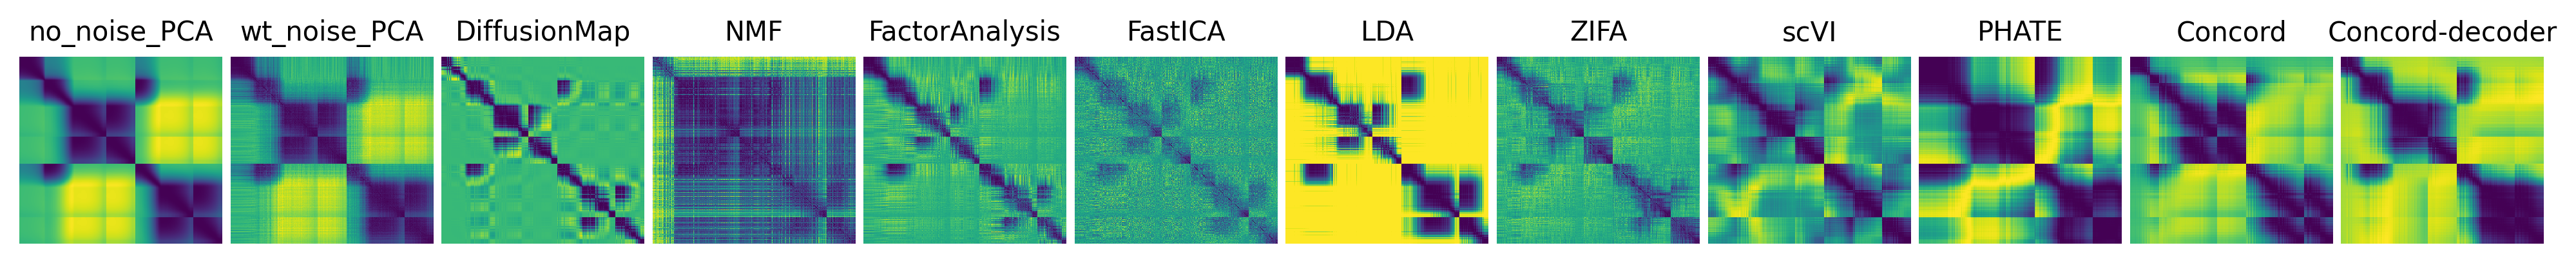

In [37]:
ccd.pl.plot_distance_heatmap(geometry_full['cell_distance_corr']['distance'], n_cols = 12, figsize=(1.1,1.3), cbar=False, dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.svg")

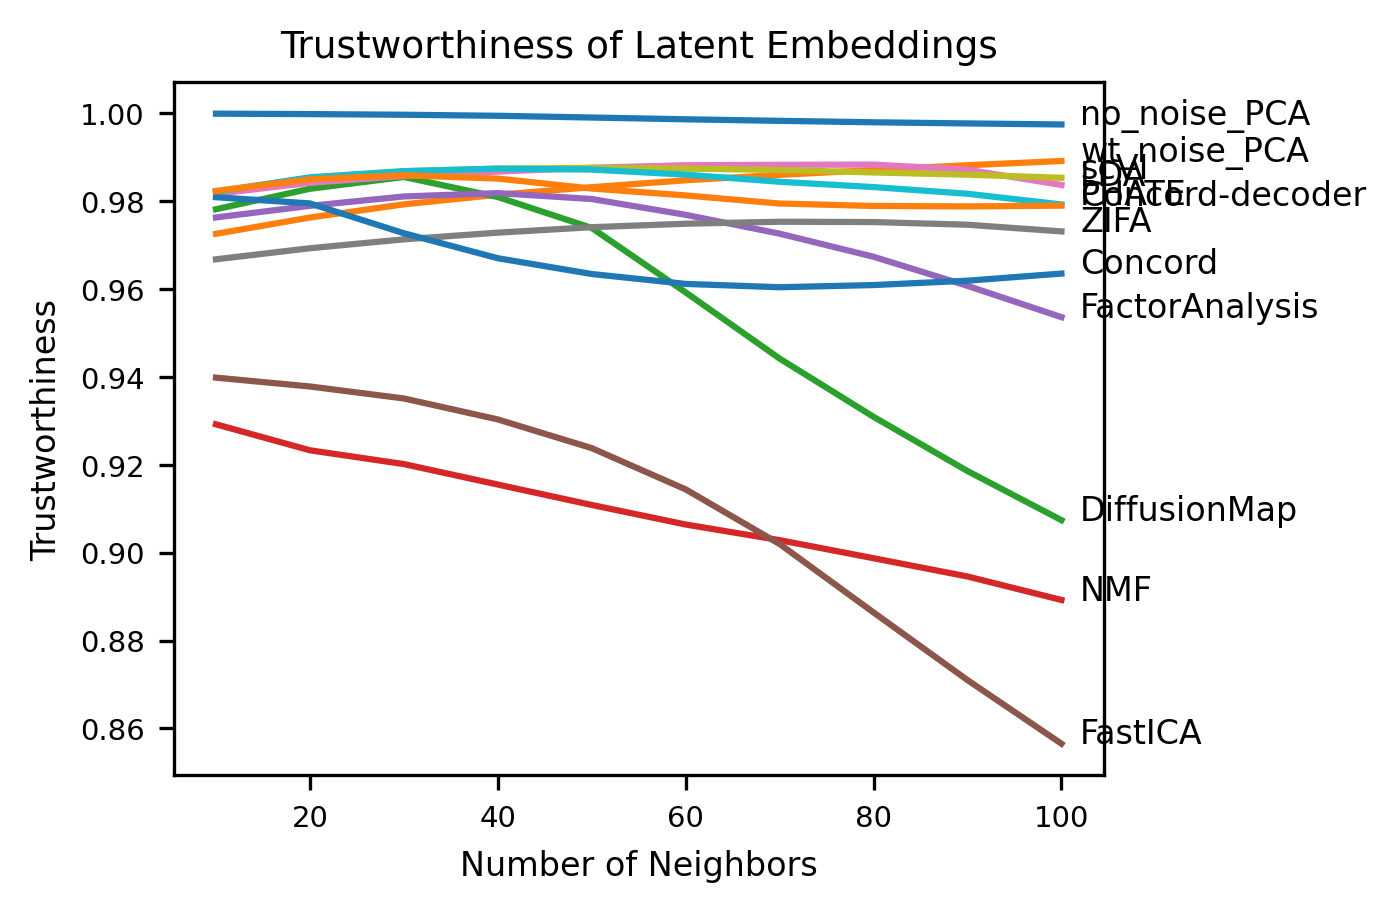

In [43]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, legend=False, save_path=save_dir / f"trustworthiness_{groundtruth_key}_{file_suffix}.pdf", figsize=(4,3))

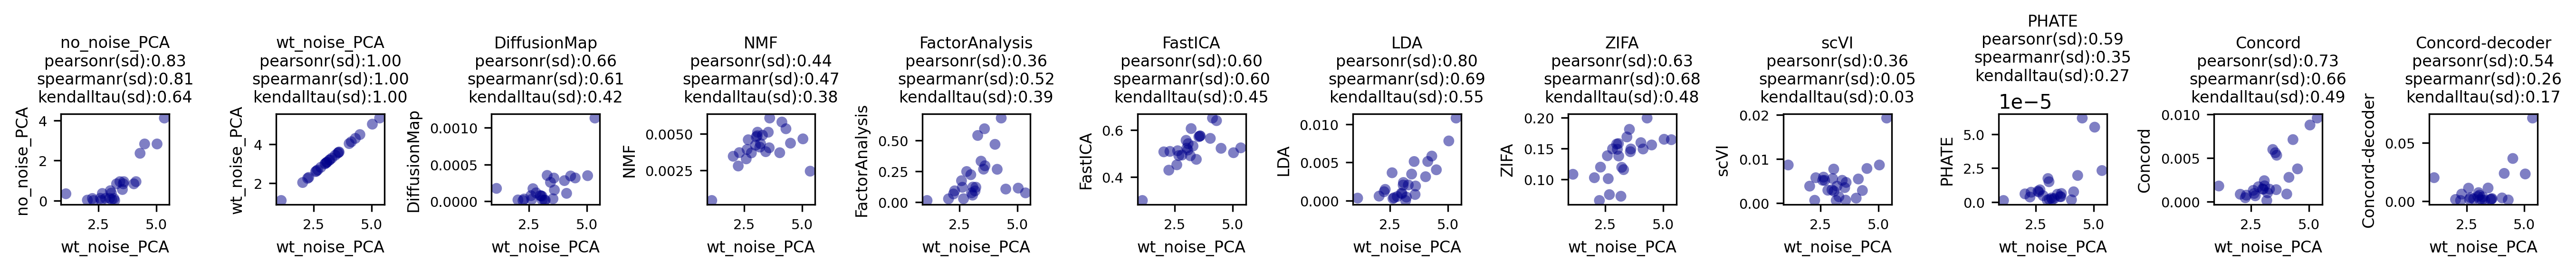

In [39]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['state_dispersion_corr']['dispersion'], 
    correlation= geometry_full['state_dispersion_corr']['correlation'],
    s=30, c='darkblue',
    ground_key = groundtruth_key,
    n_cols = 12, figsize=(1.5,2.0), dpi=300, save_path=save_dir / f"state_dispersion_scatter_{groundtruth_key}_{file_suffix}.pdf")